In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')




In [59]:
df=pd.read_csv('parkinson_disease.csv')
pd.set_option('display.max_columns',10)
df.sample(5)


,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
335,111,1,0.82835,0.68926,0.53644,...,17.1524,45.7353,47.5125,91.9865,0
279,93,1,0.83201,0.73877,0.34552,...,4.1260,6.1704,3.4549,4.2993,1
482,160,1,0.88492,0.59296,0.34836,...,4.8857,3.6936,3.8053,3.9056,1
6,2,1,0.76095,0.62145,0.54543,...,4.6206,12.8353,13.8300,7.7693,1
594,198,1,0.75638,0.70234,0.61218,...,1.6933,1.9482,3.7304,11.2957,0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


In [65]:
df.isnull().sum().sum()


0

In [67]:
df = df.groupby('id').mean().reset_index()

# Drop the 'id' column
df.drop('id', axis=1, inplace=True)

# Show the resu

In [70]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            # If the correlation between the two features is more than 0.7, remove it
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
            
    df = df[filtered_columns]
df.shape

(252, 287)

In [71]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

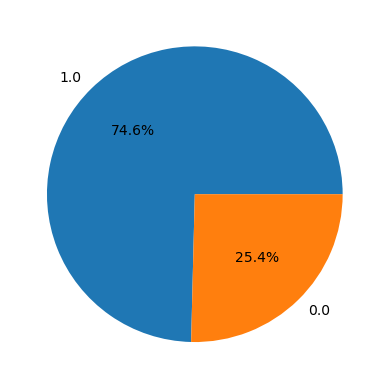

In [76]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [78]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

In [88]:
from sklearn.metrics import roc_auc_score as ras
from sklearn.datasets import make_classification

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)] 
for model in models:
    model.fit(X_resampled, y_resampled)
    print(f'{model} : ')

    train_preds = model.predict(X_resampled)
    print('Training Accuracy : ', ras(y_resampled, train_preds))

    val_preds = model.predict(X_val)
    print('Validation Accuracy : ', ras(y_val, val_preds))
    print()

LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.8864902506963789
Validation Accuracy :  0.8722222222222223

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.8722222222222222

SVC(probability=True) : 
Training Accurac

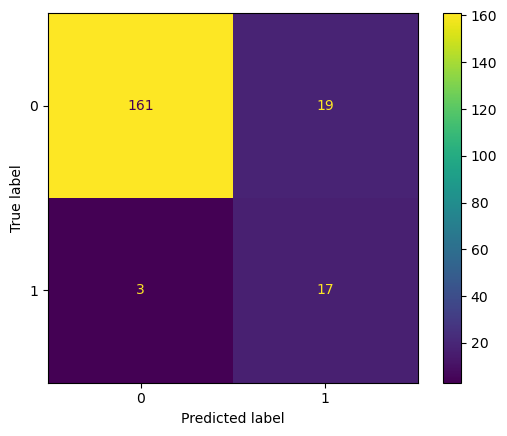

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay


# Display confusion matrix for the first model (Logistic Regression)
ConfusionMatrixDisplay.from_estimator(models[0], X_val, y_val)
#plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94       180
           1       0.47      0.85      0.61        20

    accuracy                           0.89       200
   macro avg       0.73      0.87      0.77       200
weighted avg       0.93      0.89      0.90       200

